In [12]:
import math
import pyblake2

import base58
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

% matplotlib inline
plt.style.use('elegant.mplstyle')

MAX_BASE_TARGET = np.power(2, 32)
MIN_BASE_TARGET = 9
MAX_SIGNATURE = bytes([0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff])


def fast_hash(message):
    blake_hash = pyblake2.blake2b(digest_size=32)
    blake_hash.update(message)

    return blake_hash.digest()


def generation_signature(prev_generation_signature, generator_pk):
    b = prev_generation_signature + generator_pk
    return fast_hash(b)


def target(p_target, p_ts, c_ts, balance):
    eta = c_ts - p_ts
    return p_target * eta * balance


def norm_bt(base_target):
    if base_target < MIN_BASE_TARGET:
        return MIN_BASE_TARGET
    if base_target > MAX_BASE_TARGET:
        return MAX_BASE_TARGET
    return int(base_target)


TARGET_BT = 60
MAX_RATIO = 67
MIN_RATIO = 53
GAMMA = 0.64


def new_calc_base_target(previous_base_target, block_time_delta):
    if block_time_delta > TARGET_BT * 1.1:
        return norm_bt(round(previous_base_target * 1.01))
    if block_time_delta < TARGET_BT * 0.9:
        return norm_bt(round(previous_base_target * 0.99))
    return previous_base_target


def calculate_base_target(previous_base_target, block_time_delta):
    if block_time_delta > TARGET_BT:
        r = previous_base_target * min(block_time_delta, MAX_RATIO) / TARGET_BT
    else:
        r = previous_base_target - previous_base_target * GAMMA * \
            (TARGET_BT - max(block_time_delta, MIN_RATIO)) / TARGET_BT

    return norm_bt(round(r))


def calc_bt(p_bt, h, block_time):
    if h % 2 == 0:
        return calculate_base_target(p_bt, block_time)
        # return new_calc_base_target(p_bt, block_time)
    else:
        return p_bt


def new_next_block_time_delta(signature, base_target, balance):
    h = corrected_hit(signature)
    a = int(balance) * int(base_target)
    r = (h * CORRECTION) / a
    return math.log2(1 + r) * 120


def old_next_block_time_delta(signature, base_target, balance):
    return hit(signature) / (int(balance) * int(base_target))


def append_block_time_delta(timestamps, block_time_delta):
    return np.append(timestamps[-2:], block_time_delta)


def mean_last_blocks_time_delta(timestamps, block_time_delta):
    ts = append_block_time_delta(timestamps, block_time_delta)
    return ts.mean()


def hit(signature):
    rbs = bytearray(signature[:8])
    rbs.reverse()
    result = int.from_bytes(rbs, byteorder="big", signed=False)
    return result


MAX_HIT = hit(MAX_SIGNATURE)
CORRECTION = MAX_HIT / math.log2(MAX_HIT)


def corrected_hit(signature):
    h = hit(signature)
    x = h / MAX_HIT
    y = math.fabs(math.log2(x))
    return y


def random_addresses(n):
    result = np.zeros(n, dtype='|S32')
    for x in np.nditer(result, op_flags=['readwrite']):
        x[...] = np.random.bytes(32)
    return result


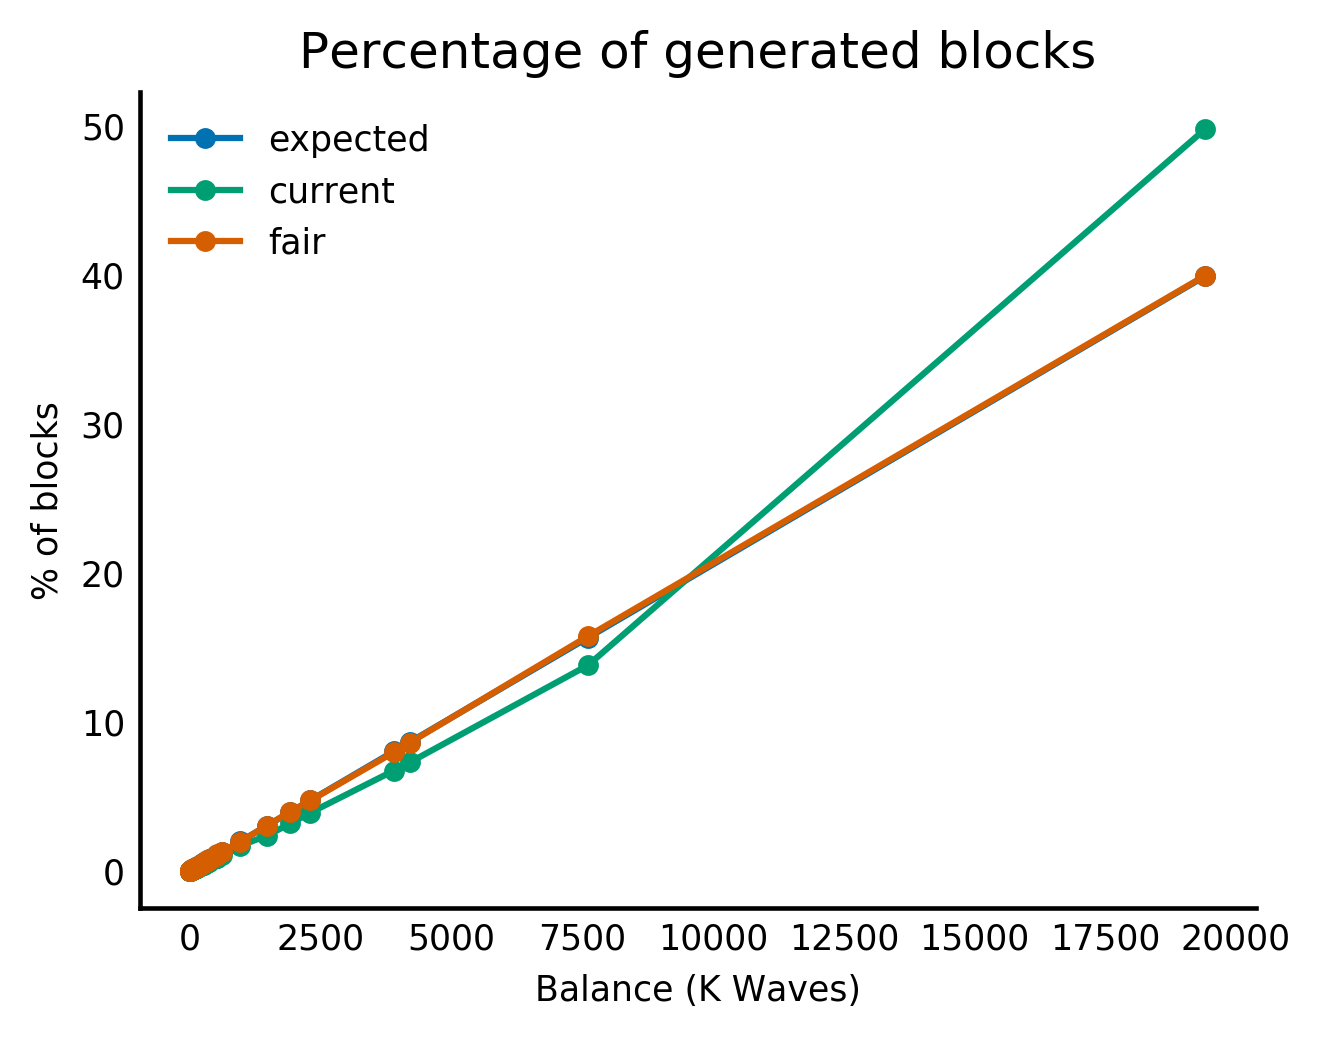

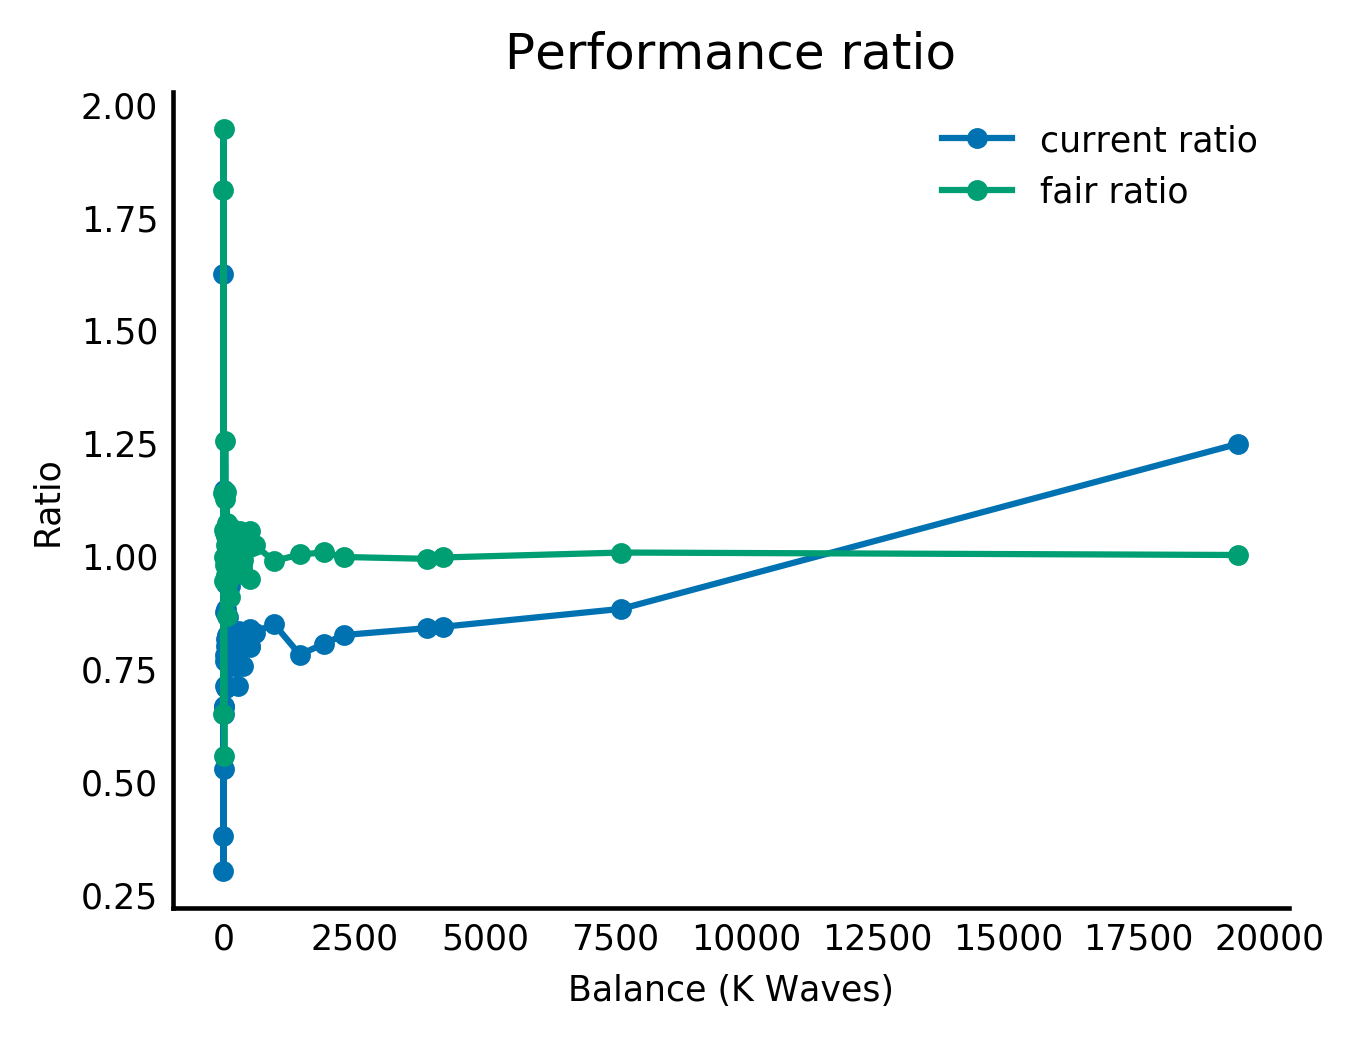

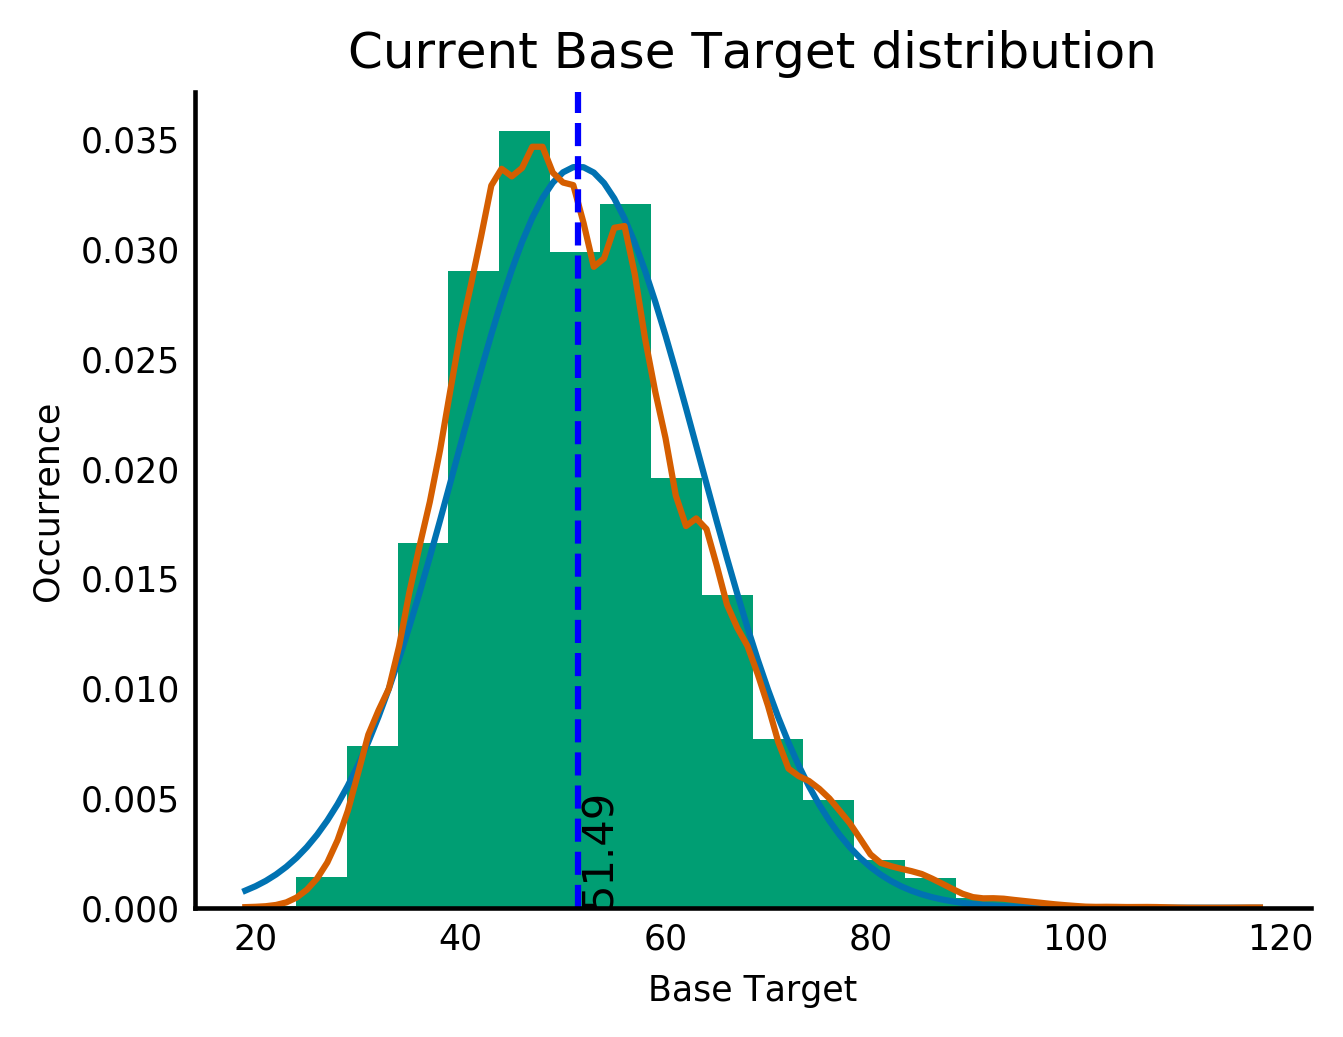

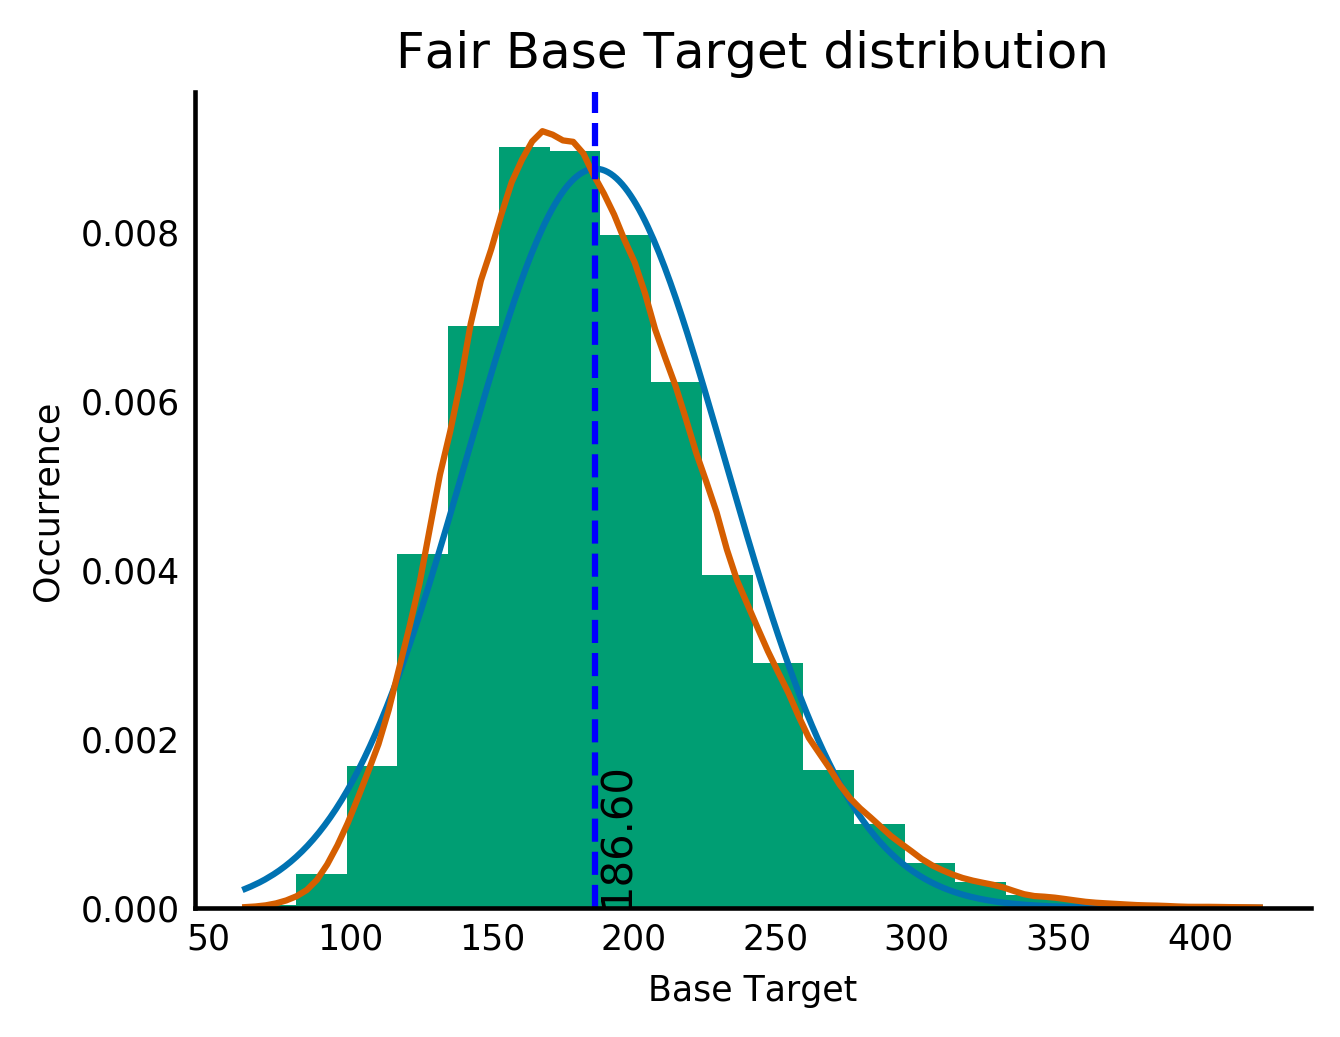

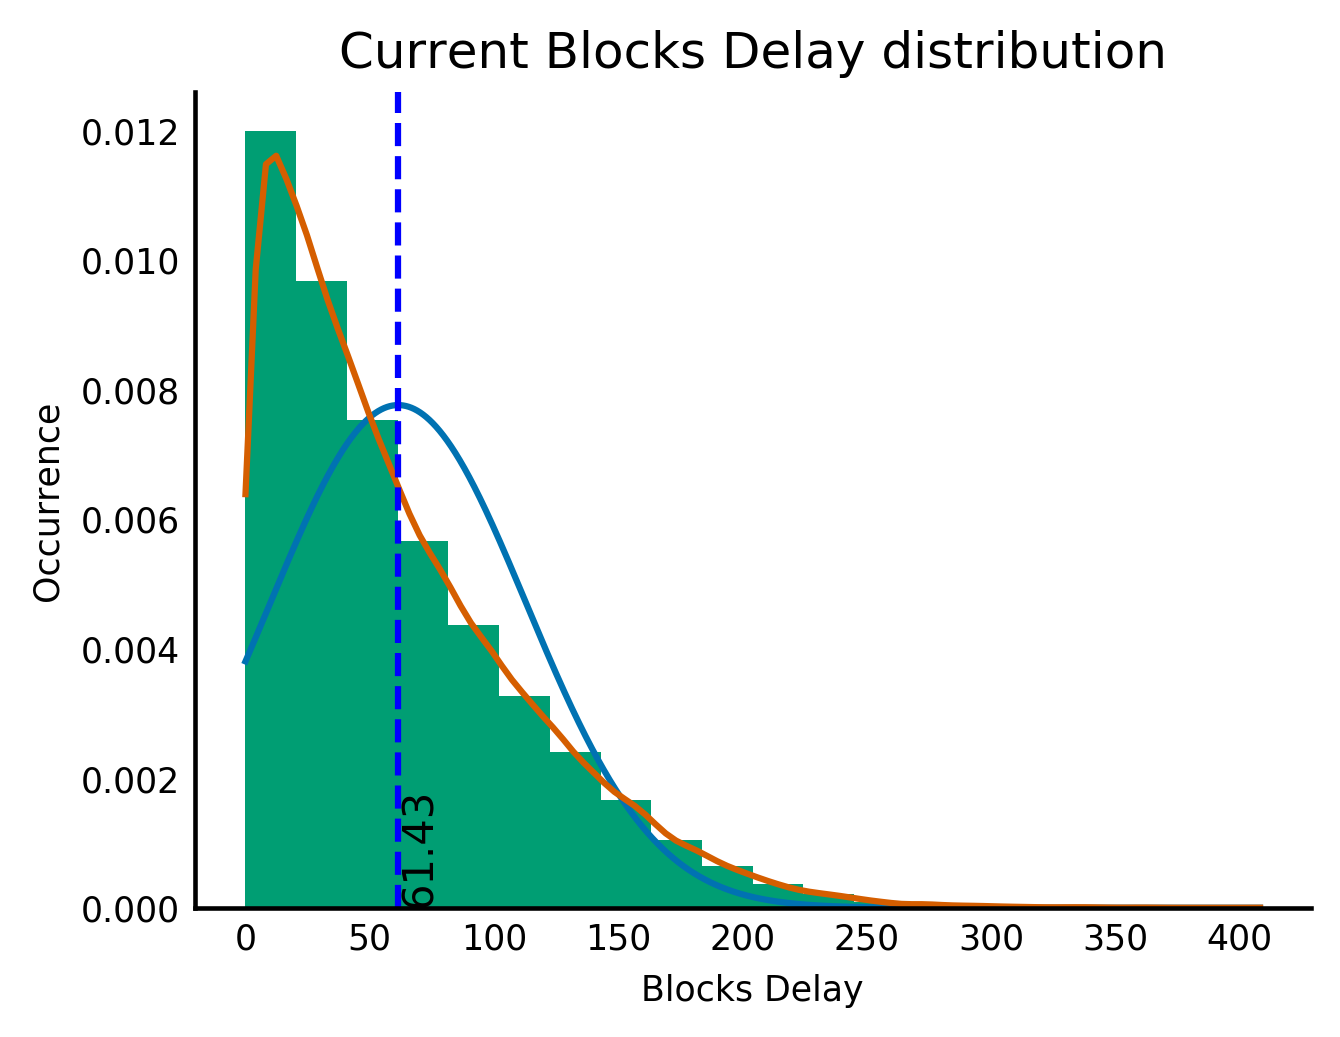

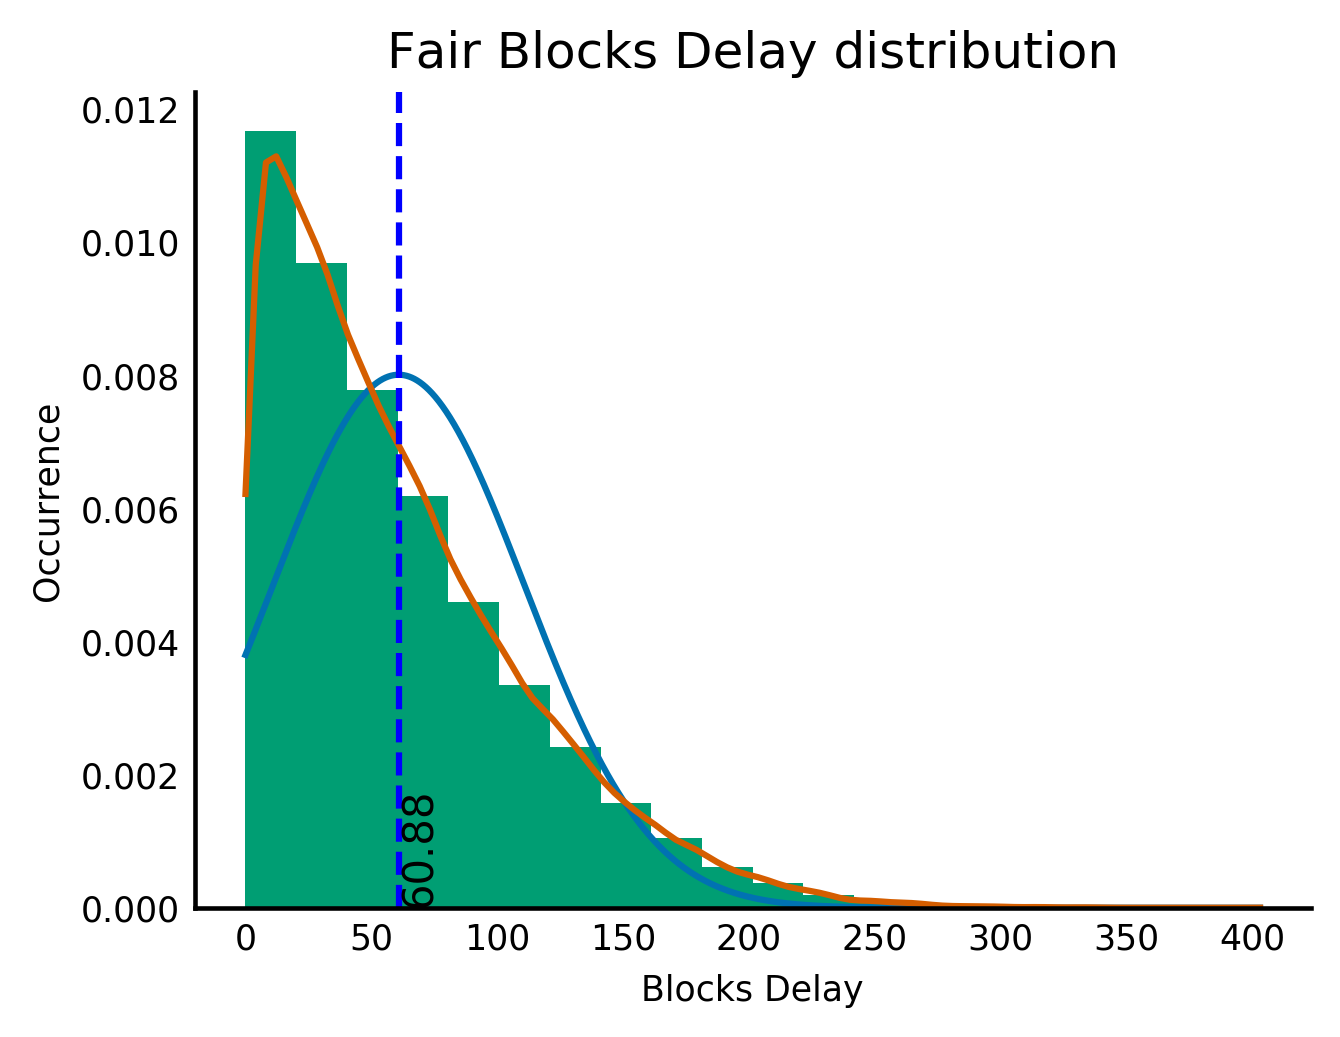

In [13]:
COIN = 100000000
MAX_TARGET = int.from_bytes(bytes([0xff for _ in range(0, 32)]), byteorder="big", signed=False)  # 153722867280912930

GENESIS_SIGNATURE = base58.b58decode("11111111111111111111111111111111")
GENESIS_BASE_TARGET = 153722867

TESTNET_BALANCES = [689302, 570023, 535684, 412952, 371495, 371366, 361823, 361615, 361602, 361071, 359963, 291617,
                    98203]
MAINNET_BALANCES = [19402700, 7609832, 4203575, 3895035, 2300584, 1918631, 1462577, 962112, 601218, 513761, 509809,
                    500482, 379315, 367370, 362385, 317670, 304980, 299280, 272840, 250662, 208514, 150137, 142804,
                    135217, 130062, 129384, 126807, 117530, 100004, 93621, 88687, 84233, 73057, 71522, 66847, 63899,
                    56793, 55948, 50000, 49319, 47447, 42024, 34943, 31506, 28360, 21209, 17533, 7227, 4397, 3005, 2767,
                    1614, 1500, 1284]

BALANCES = MAINNET_BALANCES

count = len(BALANCES)
addresses = random_addresses(count)

balances = np.array(BALANCES, dtype="object") * COIN
old_forged_blocks_counts = np.zeros(count, dtype="int32")
new_forged_blocks_counts = np.zeros(count, dtype="int32")

old_block_generation_signature = b''
new_block_generation_signature = b''
old_base_target = GENESIS_BASE_TARGET
new_base_target = GENESIS_BASE_TARGET

old_block_time_delta = 0
new_block_time_delta = 0

old_stack = np.array([0], dtype="float32")
new_stack = np.array([0], dtype="float32")

warm = np.arange(start=2, stop=1000)
heights = np.arange(start=1001, stop=101000)
old_all_base_targets = np.zeros(len(heights))
old_all_block_time_deltas = np.zeros(len(heights))
new_all_base_targets = np.zeros(len(heights))
new_all_block_time_deltas = np.zeros(len(heights))

for (k), h in np.ndenumerate(warm):
    old_blocks_generation_signatures = np.array(
        [generation_signature(old_block_generation_signature, a) for a in addresses])
    new_blocks_generation_signatures = np.array(
        [generation_signature(new_block_generation_signature, a) for a in addresses])
    old_tmp = np.rec.fromarrays((old_blocks_generation_signatures, balances))
    new_tmp = np.rec.fromarrays((new_blocks_generation_signatures, balances))
    old_blocks_times = np.array([old_next_block_time_delta(x[0], old_base_target, x[1]) for x in old_tmp])
    new_blocks_times = np.array([new_next_block_time_delta(x[0], new_base_target, x[1]) for x in new_tmp])
    old_base_targets = np.array([calc_bt(old_base_target, h, t) for t in old_blocks_times])
    new_base_targets = np.array([calc_bt(new_base_target, h, t) for t in new_blocks_times])
    old_min_index = old_blocks_times.argmin()
    new_min_index = new_blocks_times.argmin()
    old_block_time_delta = old_blocks_times.min()
    new_block_time_delta = new_blocks_times.min()
    old_stack = append_block_time_delta(old_stack, old_block_time_delta)
    new_stack = append_block_time_delta(new_stack, new_block_time_delta)
    old_base_target = old_base_targets[old_min_index]
    new_base_target = new_base_targets[new_min_index]
    old_block_generation_signature = old_blocks_generation_signatures[old_min_index]
    new_block_generation_signature = new_blocks_generation_signatures[new_min_index]

for (k), h in np.ndenumerate(heights):
    
    # if h == 100000:
    #     balances[0] = 1000 * COIN
        
    i = k[0]
    old_blocks_generation_signatures = np.array(
        [generation_signature(old_block_generation_signature, a) for a in addresses])
    new_blocks_generation_signatures = np.array(
        [generation_signature(new_block_generation_signature, a) for a in addresses])
    old_tmp = np.rec.fromarrays((old_blocks_generation_signatures, balances))
    new_tmp = np.rec.fromarrays((new_blocks_generation_signatures, balances))
    old_blocks_times = np.array([old_next_block_time_delta(x[0], old_base_target, x[1]) for x in old_tmp])
    new_blocks_times = np.array([new_next_block_time_delta(x[0], new_base_target, x[1]) for x in new_tmp])
    old_base_targets = np.array([calc_bt(old_base_target, h, t) for t in old_blocks_times])
    new_base_targets = np.array([calc_bt(new_base_target, h, t) for t in new_blocks_times])
    old_min_index = old_blocks_times.argmin()
    new_min_index = new_blocks_times.argmin()
    old_block_time_delta = old_blocks_times.min()
    new_block_time_delta = new_blocks_times.min()
    old_stack = append_block_time_delta(old_stack, old_block_time_delta)
    new_stack = append_block_time_delta(new_stack, new_block_time_delta)
    old_base_target = old_base_targets[old_min_index]
    new_base_target = new_base_targets[new_min_index]
    old_block_generation_signature = old_blocks_generation_signatures[old_min_index]
    new_block_generation_signature = new_blocks_generation_signatures[new_min_index]
    
    old_forged_blocks_counts[old_min_index] = old_forged_blocks_counts[old_min_index] + 1
    new_forged_blocks_counts[new_min_index] = new_forged_blocks_counts[new_min_index] + 1
    
    old_all_base_targets[i] = old_base_target
    old_all_block_time_deltas[i] = old_block_time_delta
    new_all_base_targets[i] = new_base_target
    new_all_block_time_deltas[i] = new_block_time_delta

expected = balances / balances.sum()
old_actual = old_forged_blocks_counts / old_forged_blocks_counts.sum()
old_rate = old_actual / expected

new_actual = new_forged_blocks_counts / new_forged_blocks_counts.sum()
new_rate = new_actual / expected

plt.title('Percentage of generated blocks')
plt.xlabel('Balance (K Waves)')
plt.ylabel('% of blocks')
plt.plot(balances / (COIN * 1000), expected * 100, 'o-')
plt.plot(balances / (COIN * 1000), old_actual * 100, 'o-')
plt.plot(balances / (COIN * 1000), new_actual * 100, 'o-')
plt.legend(['expected', 'current', 'fair'])
plt.savefig('balance-gen.png')
plt.show()

plt.title('Performance ratio')
plt.xlabel('Balance (K Waves)')
plt.ylabel('Ratio')
plt.plot(balances / (COIN * 1000), old_rate, 'o-')
plt.plot(balances / (COIN * 1000), new_rate, 'o-')
plt.legend(['current ratio', 'fair ratio'])
plt.savefig('generation-rate.png')
plt.show()

plt.title('Current Base Target distribution')
plt.xlabel('Base Target')
plt.ylabel('Occurrence')
old_bt = sorted(old_all_base_targets)
old_bt_fit = stats.norm.pdf(old_bt, np.mean(old_bt), np.std(old_bt))
plt.plot(old_bt, old_bt_fit)
plt.hist(old_bt, normed=True, bins=20)
d0 = stats.gaussian_kde(old_all_base_targets)
x0 = np.linspace(old_all_base_targets.min(), old_all_base_targets.max(), 100)
plt.plot(x0, d0(x0))
obt_mean = np.mean(old_all_base_targets)
plt.axvline(obt_mean, color='b', linestyle='dashed')
plt.text(obt_mean, 0, "{0:0.2f}".format(obt_mean), rotation=90, verticalalignment='bottom')
plt.show()

plt.title('Fair Base Target distribution')
plt.xlabel('Base Target')
plt.ylabel('Occurrence')
new_bt = sorted(new_all_base_targets)
new_bt_fit = stats.norm.pdf(new_bt, np.mean(new_bt), np.std(new_bt))
plt.plot(new_bt, new_bt_fit)
plt.hist(new_bt, normed=True, bins=20)
d1 = stats.gaussian_kde(new_all_base_targets)
x1 = np.linspace(new_all_base_targets.min(), new_all_base_targets.max(), 100)
plt.plot(x1, d1(x1))
nbt_mean = np.mean(new_all_base_targets)
plt.axvline(nbt_mean, color='b', linestyle='dashed')
plt.text(nbt_mean, 0, "{0:0.2f}".format(nbt_mean), rotation=90, verticalalignment='bottom')
plt.show()

plt.title('Current Blocks Delay distribution')
plt.xlabel('Blocks Delay')
plt.ylabel('Occurrence')
old_deltas = sorted(old_all_block_time_deltas)
old_deltas_fit = stats.norm.pdf(old_deltas, np.mean(old_deltas), np.std(old_deltas))
plt.plot(old_deltas, old_deltas_fit)
plt.hist(old_deltas, normed=True, bins=20)
d2 = stats.gaussian_kde(old_all_block_time_deltas)
x2 = np.linspace(old_all_block_time_deltas.min(), old_all_block_time_deltas.max(), 100)
plt.plot(x2, d2(x2))
od_mean = np.mean(old_deltas)
plt.axvline(od_mean, color='b', linestyle='dashed')
plt.text(od_mean, 0, "{0:0.2f}".format(od_mean), rotation=90, verticalalignment='bottom')
plt.show()

plt.title('Fair Blocks Delay distribution')
plt.xlabel('Blocks Delay')
plt.ylabel('Occurrence')
new_deltas = sorted(new_all_block_time_deltas)
new_deltas_fit = stats.norm.pdf(new_deltas, np.mean(new_deltas), np.std(new_deltas))
plt.plot(new_deltas, new_deltas_fit)
plt.hist(new_deltas, normed=True, bins=20)
d3 = stats.gaussian_kde(new_all_block_time_deltas)
x3 = np.linspace(new_all_block_time_deltas.min(), new_all_block_time_deltas.max(), 100)
plt.plot(x3, d3(x3))
nd_mean = np.mean(new_deltas)
plt.axvline(nd_mean, color='b', linestyle='dashed')
plt.text(nd_mean, 0, "{0:0.2f}".format(nd_mean), rotation=90, verticalalignment='bottom')
plt.show()
